In [ ]:
import pandas as pd

df = pd.read_csv('/content/data.csv')
df = df.reset_index(drop=True)
df.head()

,Nom,Viet
0,𤾓𢆥𥪞𡎝𠊛些,Trăm năm trong cõi người ta
1,𫳘才𫳘命窖𱺵恄𠑬,Chữ tài chữ mệnh khéo là ghét nhau
2,𣦰戈𱥺局𣷭橷,Trải qua một cuộc bể dâu
3,仍調𬂙𧡊㐌𤴬疸𢚸,Những điều trông thấy đã đau đớn lòng
4,𨓐咦彼嗇斯豐,Lạ gì bỉ sắc tư phong


In [ ]:
import re
from unicodedata import normalize

def clean_text(text):
    text = normalize('NFD', text.lower())
    #text = re.sub('[^A-Za-z ]+', '', text)
    return text

def clean_and_prepare_text(text):
    text = '[start] ' + clean_text(text) + ' [end]'
    return text

df['Nom'] = df['Nom'].apply(lambda row: clean_text(row))
df['Viet'] = df['Viet'].apply(lambda row: clean_and_prepare_text(row))
df.head()

,Nom,Viet
0,𤾓𢆥𥪞𡎝𠊛些,[start] trăm năm trong cõi người ta [end]
1,𫳘才𫳘命窖𱺵恄𠑬,[start] chữ tài chữ mệnh khéo là ghé...
2,𣦰戈𱥺局𣷭橷,[start] trải qua một cuộc bể dâu [end]
3,仍調𬂙𧡊㐌𤴬疸𢚸,[start] những điều trông thấy đã đau đ...
4,𨓐咦彼嗇斯豐,[start] lạ gì bỉ sắc tư phong [end]


In [ ]:
nm = df['Nom']
vi = df['Viet']

nm_max_len = max(len(line.split()) for line in nm)
vi_max_len = max(len(line.split()) for line in vi)
sequence_len = max(nm_max_len, vi_max_len)

nm_max_len, vi_max_len, sequence_len

(1, 10, 10)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nm_tokenizer = Tokenizer(char_level = True)
nm_tokenizer.fit_on_texts(nm)
nm_sequences = nm_tokenizer.texts_to_sequences(nm)
nm_x = pad_sequences(nm_sequences, maxlen=sequence_len, padding='post')

vi_tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@\\^_`{|}~\t\n')
vi_tokenizer.fit_on_texts(vi)
vi_sequences = vi_tokenizer.texts_to_sequences(vi)
vi_y = pad_sequences(vi_sequences, maxlen=sequence_len + 1, padding='post')

In [ ]:
nm_vocab_size = len(nm_tokenizer.word_index)
vi_vocab_size = len(vi_tokenizer.word_index)

print(f'Vocabulary size (Nom): {nm_vocab_size}')
print(f'Vocabulary size (Quoc ngu): {vi_vocab_size}')

Vocabulary size (Nom): 3414
Vocabulary size (Quoc ngu): 2790


In [ ]:
inputs = { 'encoder_input': nm_x, 'decoder_input': vi_y[:, :-1] }
outputs = vi_y[:, 1:]

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from keras_nlp.layers import TokenAndPositionEmbedding, TransformerEncoder
from keras_nlp.layers import TransformerDecoder

np.random.seed(42)
tf.random.set_seed(42)

num_heads = 8
embed_dim = 512

encoder_input = Input(shape=(None,), dtype='int64', name='encoder_input')
x = TokenAndPositionEmbedding(nm_vocab_size, sequence_len, embed_dim)(encoder_input)
encoder_output = TransformerEncoder(embed_dim, num_heads)(x)
encoded_seq_input = Input(shape=(None, embed_dim))

decoder_input = Input(shape=(None,), dtype='int64', name='decoder_input')
x = TokenAndPositionEmbedding(vi_vocab_size, sequence_len, embed_dim, mask_zero=True)(decoder_input)
x = TransformerDecoder(embed_dim, num_heads)(x, encoded_seq_input)

decoder_output = Dense(vi_vocab_size, activation='softmax')(x)
decoder = Model([decoder_input, encoded_seq_input], decoder_output)
decoder_output = decoder([decoder_input, encoder_output])

model = Model([encoder_input, decoder_input], decoder_output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, None)]               0         []                            
                                                                                                  
 token_and_position_embeddi  (None, None, 512)            1753088   ['encoder_input[0][0]']       
 ng_8 (TokenAndPositionEmbe                                                                       
 dding)                                                                                           
                                                                                                  
 decoder_input (InputLayer)  [(None, None)]               0         []                            
                                                                                            

In [ ]:
#from tensorflow.keras.callbacks import EarlyStopping

#callback = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
hist = model.fit(inputs, outputs, epochs=50, validation_split=0.1)

Epoch 1/50
139/139 [==============================] - 18s 66ms/step - loss: 3.3345 - accuracy: 0.5509 - val_loss: 1.2893 - val_accuracy: 0.8442
Epoch 2/50
139/139 [==============================] - 4s 31ms/step - loss: 0.5393 - accuracy: 0.9205 - val_loss: 0.9275 - val_accuracy: 0.8762
Epoch 3/50
139/139 [==============================] - 3s 19ms/step - loss: 0.1588 - accuracy: 0.9656 - val_loss: 0.8846 - val_accuracy: 0.8846
Epoch 4/50
139/139 [==============================] - 2s 17ms/step - loss: 0.0834 - accuracy: 0.9807 - val_loss: 0.9018 - val_accuracy: 0.8848
Epoch 5/50
139/139 [==============================] - 3s 25ms/step - loss: 0.0716 - accuracy: 0.9838 - val_loss: 0.9223 - val_accuracy: 0.8789
Epoch 6/50
139/139 [==============================] - 3s 23ms/step - loss: 0.0632 - accuracy: 0.9862 - val_loss: 0.9390 - val_accuracy: 0.8792
Epoch 7/50
139/139 [==============================] - 3s 18ms/step - loss: 0.0544 - accuracy: 0.9884 - val_loss: 0.9306 - val_accuracy: 0.882

[]

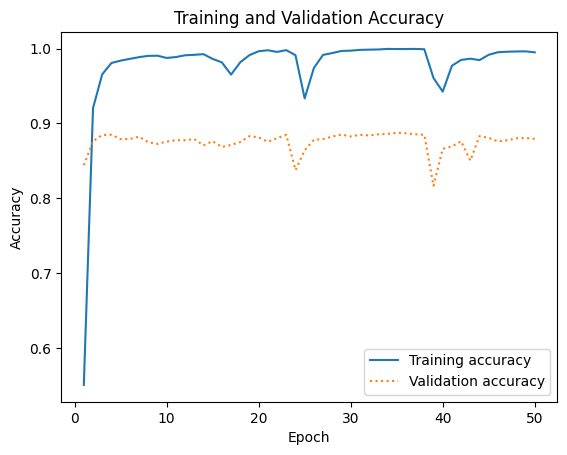

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [ ]:
def translate_text(text, model, nm_tokenizer, vi_tokenizer, vi_index_lookup, sequence_len):
    input_sequence = nm_tokenizer.texts_to_sequences([text])
    padded_input_sequence = pad_sequences(input_sequence, maxlen=sequence_len, padding='post')
    decoded_text = '[start]'

    for i in range(sequence_len):
        target_sequence = vi_tokenizer.texts_to_sequences([decoded_text])
        padded_target_sequence = pad_sequences(target_sequence, maxlen=sequence_len, padding='post')[:, :-1]

        prediction = model([padded_input_sequence, padded_target_sequence])

        idx = np.argmax(prediction[0, i, :]) - 1
        token = vi_index_lookup[idx]
        decoded_text += ' ' + token

        if token == '[end]':
            break

    return decoded_text[8:-6] # Remove [start] and [end] tokens

vi_vocab = vi_tokenizer.word_index
vi_index_lookup = dict(zip(range(len(vi_vocab)), vi_vocab))

In [ ]:
translate_text('身㛪辰𤽸分㛪𧷺', model, nm_tokenizer, vi_tokenizer, vi_index_lookup, sequence_len)

'thân em thì trắng phân em tròn'